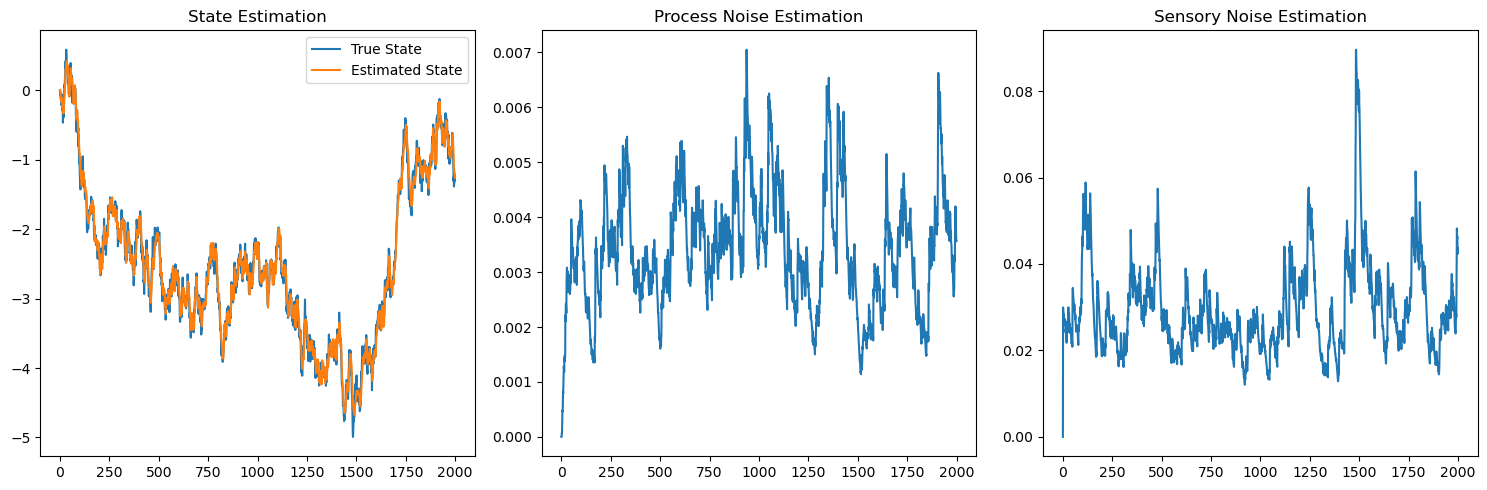

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the true dynamics and observations
T = 2000
x_true = np.zeros(T)
y_obs = np.zeros(T)

phi = 0.95

# Generate a true state with increasing process noise (AR(1) noise)
n_process = np.zeros(T)
for t in range(1, T):
    n_process[t] = np.random.randn()*0.1
    # n_process[t] = phi * n_process[t-1] + np.random.randn()
    x_true[t] = x_true[t-1] + n_process[t]

# Generate observations with a more pronounced periodic sensory noise (AR(1) noise)
n_sensory = np.zeros(T)
for t in range(T):
    n_sensory[t] =  np.random.randn() * 0.1
    #n_sensory[t] = 2*np.sin(t / 10) + phi * n_sensory[t-1] + np.random.randn() * 0.2
    y_obs[t] = x_true[t] + n_sensory[t]

# Initialize beliefs
x_belief = np.zeros(T)
process_noise_belief = np.zeros(T)
sensory_noise_belief = np.zeros(T)

alpha = 0.05  # Reduced learning rate

for t in range(1, T):
    # Prediction step
    x_predict = x_belief[t-1]
    prediction_error = y_obs[t] - x_predict
    
    # Update sensory noise belief
    sensory_noise_belief[t] = (1 - alpha) * sensory_noise_belief[t-1] + alpha * ((prediction_error-process_noise)**2)
    
    # Update state belief using Kalman-like update
    x_belief[t] = x_predict +  0.01*prediction_error / sensory_noise_belief[t]  
    
    # Update process noise belief (using difference in beliefs)
    process_noise = (x_belief[t] - x_belief[t-1])**2
    # process_noise = (x_belief[t] - x_belief[t-1] - phi * n_process[t-1])**2
    process_noise_belief[t] = (1 - alpha) * process_noise_belief[t-1] + alpha * process_noise

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x_true, label='True State')
plt.plot(x_belief, label='Estimated State')
plt.legend()
plt.title('State Estimation')

plt.subplot(1, 3, 2)
plt.plot(process_noise_belief, label='Estimated Process Noise')
plt.title('Process Noise Estimation')

plt.subplot(1, 3, 3)
plt.plot(sensory_noise_belief, label='Estimated Sensory Noise')
plt.title('Sensory Noise Estimation')

plt.tight_layout()
plt.show()

In [11]:
print(range(T))

range(0, 2000)


In [12]:
print(np.mean(process_noise_belief[1500:2000]))
print(np.mean(sensory_noise_belief[1500:2000]))



0.003106615760979941
0.03203849449052882


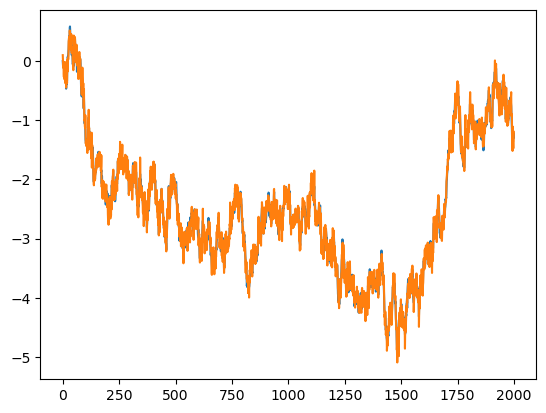

In [13]:
plt.figure()
plt.plot(x_true)
plt.plot(y_obs)